In [1]:
import bhnerf
from astropy import units
import jax
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from bhnerf import constants as consts

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vh4bu1z1 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



2023-04-12 13:57:14.194760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs


Generate synthetic ALMA lightcurves 
---
Polarized lightcurves corresponding to ALMA observation times on April 11, 2017. \
Generate synthetic hot-spot data and the resulting polarized image-plane.

In [2]:
"""
Load ALMA Data and time average over a window
"""
data_path = '../data/Apr11_HI.dat'
alma_lc = pd.read_csv(data_path)

t0 = 9. + 20./60.           # UTC
t7 = t0 + 68./60. + 35./60. # UTC

window_size = 8
alma_lc_loops = alma_lc.loc[np.bitwise_and(alma_lc['time']>=t0, alma_lc['time']<=t7)]
alma_lc_means = alma_lc_loops.rolling(window_size).mean().loc[::window_size].dropna()
t_frames = alma_lc_means['time'].values * units.hr

%matplotlib widget
fig, axes = plt.subplots(1, 4, figsize=(10,3))
for s, ax in zip(['I', 'Q', 'U', 'V'], axes):
    ax.errorbar(alma_lc.time,  alma_lc[s], fmt='.', ecolor='black')
    ax.errorbar(alma_lc_means.time,  alma_lc_means[s], fmt='.', color='tab:orange')
    ymin = alma_lc[s].min() - 0.2*np.abs(alma_lc[s].min())
    ymax = alma_lc[s].max() + 0.2*np.abs(alma_lc[s].max())
    ax.fill_between([t0, t7], [ymax, ymax], ymin, alpha=0.3, color='gray')
    ax.set_ylim([ymin, ymax])
    ax.set_title('{} lightcurve'.format(s))
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
%matplotlib widget
plt.figure(figsize=(3,3))
plt.scatter(alma_lc_means['Q'], alma_lc_means['U'], c=alma_lc_means['time'], cmap=plt.cm.get_cmap('inferno'), s=1)
plt.title('QU Loop')
plt.xlim(-0.25, 0.2)
plt.ylim(-0.35, 0.05)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-0.35, 0.05)

In [4]:
stokes = ['Q', 'U']
target = np.array(alma_lc_means[stokes])

t_model = np.linspace(9.2, 11.15, 100) * units.hr
rot_angle = np.deg2rad(120)
inclination = np.deg2rad(21.0)

orbit_radius = 11.0
spin = 0.0

Omega_dir = 'cw'
rot_sign = {'cw': -1, 'ccw': 1}

b_consts = [0, 1, 0]
Q_frac = 0.85
V_frac = 0

# Q_sha, U_sha = 0.045, -0.155
I_sha = 2.4  # Jy
P_sha = 0.16 # Jy
chi_sha = np.deg2rad(-37)
qu_sha = P_sha * np.array([np.cos(2*chi_sha), np.sin(2*chi_sha)])
iqu_sha = np.concatenate(([I_sha], qu_sha))

Point source hot-spot: semi-analytic model of Gelles et al
--

In [33]:
ngeo = 500
mbar = 0
de_rot_model = np.deg2rad(20.0)
flux_scale = 0.01

kepler_period = 2 * np.pi * (orbit_radius**(3/2) + spin) * consts.GM_c3(consts.sgra_mass.to('kg')).to('hr')
varphis = rot_sign[Omega_dir] * (2 * np.pi * (t_model - t_frames[0]) / kepler_period).value + rot_angle

observer_coords = [0, 1000.0, inclination, 0]
alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inclination, req=orbit_radius, mbar=mbar, varphis=varphis)[-2:]
geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
emission = bhnerf.emission.equatorial_ring(geos, mbar)

Omega = rot_sign[Omega_dir] * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))
umu = bhnerf.kgeo.azimuthal_velocity_vector(geos, Omega)
g = bhnerf.kgeo.doppler_factor(geos, umu)

b = bhnerf.kgeo.magnetic_field_spherical(geos, *b_consts)
J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b, Q_frac, V_frac)
iqu_semi_analytic = bhnerf.kgeo.radiative_trasfer(J, g, 1.0, np.array(geos.Sigma)).T
qu_semi_analytic = flux_scale*bhnerf.emission.rotate_evpa(iqu_semi_analytic[:, 1:], de_rot_model, axis=1) + qu_sha

In [35]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True', plot_qu=True)
axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
axes[0].axhline(qu_sha[0], linestyle='--', color='black')
axes[1].axhline(qu_sha[1], linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
de_rot_data = np.deg2rad(32.2)
alma_qu_intrinsic = bhnerf.emission.rotate_evpa(target-qu_sha, de_rot_data, axis=1)

de_rot_model = np.deg2rad(32.2 + 20.0)
qu_semi_analytic_intrinsic = flux_scale*bhnerf.emission.rotate_evpa(iqu_semi_analytic[:, 1:], de_rot_model, axis=1)
axes = bhnerf.visualization.plot_stokes_lc(alma_qu_intrinsic, stokes, t_frames, label='True', plot_qu=True)
axes[0].plot(t_model, qu_semi_analytic_intrinsic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic_intrinsic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic_intrinsic[:,0], qu_semi_analytic_intrinsic[:,1], color='r', linestyle='dotted')
    
axes[2].axvline(0.0, linestyle='--', color='black')
axes[2].axhline(0.0, linestyle='--', color='black')
#axes[0].set_ylim(-0.1, 0.16)
#axes[1].set_ylim(-0.35, -0.05)

for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Small Gaussian hotspot
---

In [5]:
hs_fwhm = 6
hs_std = hs_fwhm / 2.355
fov_M = 40.0 
rmax = fov_M / 2
GM_c3 = consts.GM_c3(consts.sgra_mass).to(t_frames.unit)

t_model = np.linspace(t_frames[0].value, 11.15, 100) * units.hr

delta_t_M = (t_frames[0]-t_model[0]) / GM_c3

# Keplerian prograde velocity field
Omega_rs = rot_sign[Omega_dir] / (orbit_radius**(3/2) + spin)

# Generate hotspot measurements (see Tutorial2)
gaussian_hs = bhnerf.emission.generate_hotspot_xr(
    resolution=(64, 64, 64), 
    rot_axis=[0.0, 0.0, 1.0], 
    rot_angle=rot_angle + np.pi/2 - float(Omega_rs * delta_t_M),
    orbit_radius=orbit_radius,
    std=hs_std,
    r_isco=bhnerf.constants.isco_pro(spin),
    fov=(fov_M, 'GM/c^2'))

geos = bhnerf.kgeo.image_plane_geos(
    spin, inclination, 
    num_alpha=128, num_beta=128, 
    alpha_range=[-fov_M/2, fov_M/2],
    beta_range=[-fov_M/2, fov_M/2])
geos.dtau[:] = 1.0
# t_injection = -float(geos.r_o)
# Omega = rot_sign[Omega_dir] * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))
Omega = Omega_rs

umu = bhnerf.kgeo.azimuthal_velocity_vector(geos, Omega)
g = bhnerf.kgeo.doppler_factor(geos, umu)
b = bhnerf.kgeo.magnetic_field_spherical(geos, *b_consts)

J = np.nan_to_num(bhnerf.kgeo.parallel_transport(geos, umu, g, b, Q_frac=Q_frac, V_frac=V_frac), 0.0)
J_inds = [['I', 'Q', 'U'].index(s) for s in stokes]
J_rot = bhnerf.emission.rotate_evpa(J[J_inds], np.deg2rad(20))

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/scratch/imaging/projects/bh_nerf/bhNeRF/bhnerf/kgeo.py:494: RuntimeWarning: invalid value encountered in sqrt
  cot_th_b = np.sqrt(1 - sin_th_b**2) / sin_th_b


In [6]:
flux_scale = 0.004
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=0, J=J_rot, slow_light=False)
qu_hs = flux_scale*image_plane_hs.sum(axis=(-1,-2)) + qu_sha

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [7]:
%matplotlib widget
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True', plot_qu=True)
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
 
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

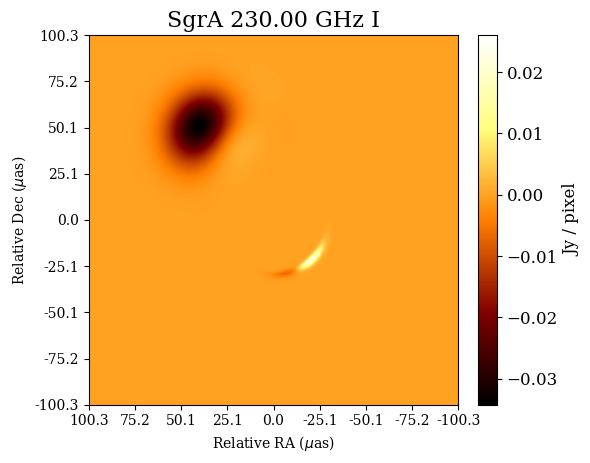

In [13]:
from bhnerf import constants as consts
import ehtim as eh
fov_rad = (fov_M * consts.GM_c2(consts.sgra_mass) / consts.sgra_distance.to('m')) * units.rad
psize = fov_rad.value / geos.alpha.size
ra = 12.513729999999999
dec = 12.39112

im = eh.image.Image(np.flipud(image_plane_hs[0,0]), psize, ra, dec)
im.display()

In [9]:
%matplotlib widget
plt.imshow(image_plane_hs[0,0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [185]:
%matplotlib widget
rot_angle = np.deg2rad(120)
gaussian_hs = bhnerf.emission.generate_hotspot_xr(
    resolution=(64, 64, 64), 
    rot_axis=[0.0, 0.0, 1.0], 
    rot_angle=rot_angle + np.pi/2 - float(Omega_rs * delta_t_M),
    orbit_radius=orbit_radius,
    std=hs_std,
    r_isco=bhnerf.constants.isco_pro(spin),
    fov=(fov_M, 'GM/c^2'))


bhnerf.visualization.ipyvolume_3d(gaussian_hs, fov_M)

In [134]:
%matplotlib widget
images = xr.DataArray(image_plane_hs[:,0], dims=['t','alpha','beta'])
images.visualization.slider()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=49, description='frame', max=99), Output()), _dom_classes=('widget-inter…

In [83]:
%matplotlib widget
plt.imshow(image_plane_hs[0,0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [71]:
%matplotlib widget
movie_list = [xr.DataArray(image_plane_hs[:,i], dims=['t','alpha','beta']) for i in range(image_plane_hs.shape[1])]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
bhnerf.visualization.animate_movies_synced(
    movie_list, axes, titles=['Q', 'U'], 
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
%matplotlib widget
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(qu_sha[0], linestyle='--', color='black')
axes[1].axhline(qu_sha[1], linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'qu_hs' is not defined

In [88]:
J_rot = rotate_evpa(J[J_inds], de_rot_model)

scale_factor = 0.0023
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=0, J=J_rot, slow_light=False
)
qu_hs = scale_factor * image_plane_hs.sum(axis=(-1,-2))

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


## Debug of dtau

In [91]:
%matplotlib widget
axes = bhnerf.visualization.plot_stokes_lc(alma_qu_intrinsic, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
%matplotlib widget
geos.dtau.isel(geo=1).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [35]:
geos.dtau[:] = 1.0
image_plane_hs1 = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=0, J=J, slow_light=False
)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [36]:
geos = bhnerf.kgeo.image_plane_geos(
    spin, inclination, 
    num_alpha=128, num_beta=128, 
    alpha_range=[-fov_M/2, fov_M/2],
    beta_range=[-fov_M/2, fov_M/2]
)

In [11]:
# Polarized emission
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=0, J=J, slow_light=False
)
iqu_hs = image_plane_hs.sum(axis=(-1,-2))

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [93]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact

def slider(sidx=1, t_dim='t', ax=None, cmap=None):
    movie = xr.DataArray(image_plane_hs1[:,sidx] * geos.dtau.isel(geo=1).data, dims=['t','alpha','beta'])
    if movie.ndim != 3:
        raise AttributeError('Movie dimensions ({}) different than 3'.format(movie.ndim))

    num_frames = movie[t_dim].size
    image_dims = list(movie.dims)
    image_dims.remove(t_dim)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    extent = [movie[image_dims[0]].min(), movie[image_dims[0]].max(),
              movie[image_dims[1]].min(), movie[image_dims[1]].max()]

    im = ax.imshow(movie.isel({t_dim: 0}), extent=extent, origin='lower', cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    
    line = axes[sidx-1].axvline(t_model[0].value, color='green', linestyle='--')

    def imshow_frame(frame):
        img = movie.isel({t_dim: frame})
        im.set_array(movie.isel({t_dim: frame}))
        cbar.mappable.set_clim([img.min(), img.max()])

    def imshow_plot(frame):
        line.set_xdata(t_model[frame].value)
        return line,
    
    def imshow_both(frame):
        return imshow_frame(frame), imshow_plot(frame)
    
    interact(imshow_both, frame=(0, num_frames-1));


In [44]:
%matplotlib widget
geos.dtau.isel(geo=1).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [74]:
iqu_hs = (image_plane_hs1 * geos.dtau.isel(geo=1).data).sum(axis=(-1,-2))

scale_factor = 0.65
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=63, description='ialpha', max=127), IntSlider(value=63, description='ibe…

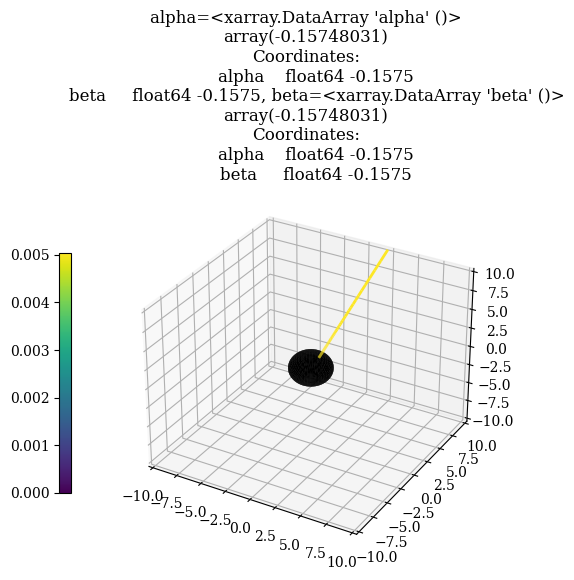

In [106]:
%matplotlib widget
bhnerf.visualization.plot_geodesic_3D(geos.dtau, geos)

In [2]:
%matplotlib widget
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(qu_sha[0], linestyle='--', color='black')
axes[1].axhline(qu_sha[1], linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()
    
slider(1)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3s38d3yq because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


NameError: name 'bhnerf' is not defined

In [59]:
iqu_hs = image_plane_hs1.sum(axis=(-1,-2))

scale_factor = 0.0022
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

In [27]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(qu_sha[0], linestyle='--', color='black')
axes[1].axhline(qu_sha[1], linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

NameError: name 'bhnerf' is not defined

In [163]:
%matplotlib widget
xr.DataArray(image_plane_hs[:,0], dims=['t','alpha','beta']).visualization.animate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [151]:
%matplotlib widget
plt.figure(figsize=(3,3))
plt.scatter(qu_hs[:,0], qu_hs[:,1], c=t_model, cmap=plt.cm.get_cmap('inferno'), s=1)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [121]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(qu_sha[0], linestyle='--', color='black')
axes[1].axhline(qu_sha[1], linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [94]:
scale_factor = 0.0023
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

In [95]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(qu_sha[0], linestyle='--', color='black')
axes[1].axhline(qu_sha[1], linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [390]:
%matplotlib widget
movie_list = [xr.DataArray(image_plane_hs[:,i], dims=['t','alpha','beta']) for i in range(image_plane_hs.shape[1])]
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
bhnerf.visualization.animate_movies_synced(
    movie_list, axes, titles=['I', 'Q', 'U'], 
    output='alma/comparison to weilgus/synthetic_hs_std{:1.1f}_no_dtau_w_shear.gif'.format(hs_std)
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [316]:
scale_factor = 0.00015
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

In [317]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Tests

In [ ]:
# WITH dtau
scale_factor = 0.42
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

In [283]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [267]:
# NO dtau
scale_factor = 0.0014
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [272]:
%matplotlib widget
movie_list = [xr.DataArray(image_plane_hs[:,i], dims=['t','alpha','beta']) for i in range(image_plane_hs.shape[1])]
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
bhnerf.visualization.animate_movies_synced(
    movie_list, axes, titles=['I', 'Q', 'U'], 
    output='alma/comparison to weilgus/synthetic_hs_std{:1.1f}_no_dtau.gif'.format(hs_std)
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [238]:
scale_factor = 0.25
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + np.array([ 0.04410198, -0.15380187])

In [239]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Gaussian hotspot
--

In [130]:
hs_diameter = 6
hs_std = hs_diameter / (2*np.sqrt(2))
fov_M = 40.0 
rmax = fov_M / 2
GM_c3 = consts.GM_c3(consts.sgra_mass).to(t_frames.unit)
delta_t_M = (t_frames[0]-t_model[0]) / GM_c3


# Keplerian prograde velocity field
# Omega = rot_sign[Omega_dir] * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))
Omega = rot_sign[Omega_dir] * np.sqrt(geos.M) / (orbit_radius**(3/2) + geos.spin * np.sqrt(geos.M))

# Generate hotspot measurements (see Tutorial2)
gaussian_hs = bhnerf.emission.generate_hotspot_xr(
    resolution=(64, 64, 64), 
    rot_axis=[0.0, 0.0, 1.0], 
    rot_angle=rot_angle + np.pi/2 - float(Omega * delta_t_M),
    orbit_radius=orbit_radius,
    std=hs_std,
    r_isco=bhnerf.constants.isco_pro(spin),
    fov=(fov_M, 'GM/c^2')
)

# Compute geodesics (see Tutorial1)
geos = bhnerf.kgeo.image_plane_geos(
    spin, inclination, 
    num_alpha=64, num_beta=64, 
    alpha_range=[-fov_M/2, fov_M/2],
    beta_range=[-fov_M/2, fov_M/2]
)
t_injection = -float(geos.r_o)

umu = bhnerf.kgeo.azimuthal_velocity_vector(geos, Omega)
# g = bhnerf.kgeo.doppler_factor(geos, umu)
g = 1
b = bhnerf.kgeo.magnetic_field(geos, *b_consts) 
J = np.nan_to_num(bhnerf.kgeo.parallel_transport(geos, umu, g, b, Q_frac=Q_frac, V_frac=V_frac), 0.0)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/scratch/imaging/projects/bh_nerf/bhNeRF/bhnerf/kgeo.py:435: RuntimeWarning: invalid value encountered in sqrt
  cot_th_b = np.sqrt(1 - sin_th_b**2) / sin_th_b


In [132]:
# Polarized emission
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=0, J=J, doppler=False, slow_light=False
)
iqu_hs = image_plane_hs.sum(axis=(-1,-2))

scale_factor = 0.18
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

In [160]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [165]:
g = bhnerf.kgeo.doppler_factor(geos, umu)
b = bhnerf.kgeo.magnetic_field(geos, *b_consts) 
J = np.nan_to_num(bhnerf.kgeo.parallel_transport(geos, umu, g, b, Q_frac=Q_frac, V_frac=V_frac), 0.0)

# Polarized emission
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=t_injection, J=J, doppler=True, slow_light=True
)
iqu_hs = image_plane_hs.sum(axis=(-1,-2))

scale_factor = 0.35
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

/scratch/imaging/projects/bh_nerf/bhNeRF/bhnerf/kgeo.py:435: RuntimeWarning: invalid value encountered in sqrt
  cot_th_b = np.sqrt(1 - sin_th_b**2) / sin_th_b
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [181]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [184]:
"""
Adding shear due to differential velocity
"""
Omega = rot_sign[Omega_dir] * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))
umu = bhnerf.kgeo.azimuthal_velocity_vector(geos, Omega)

g = bhnerf.kgeo.doppler_factor(geos, umu)
b = bhnerf.kgeo.magnetic_field(geos, *b_consts) 
J = np.nan_to_num(bhnerf.kgeo.parallel_transport(geos, umu, g, b, Q_frac=Q_frac, V_frac=V_frac), 0.0)

# Polarized emission
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection=0, J=J, doppler=True, slow_light=False
)
iqu_hs = image_plane_hs.sum(axis=(-1,-2))

scale_factor = 0.35
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [194]:
scale_factor = 0.45
qu_hs = rotate_qu(scale_factor*iqu_hs[:, 1:], angle=np.deg2rad(20)) + qu_sha

In [195]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
# Polarized emission
image_plane_hs = bhnerf.emission.image_plane_dynamics(
    gaussian_hs, geos, Omega, t_model, t_injection, J, doppler=False, slow_light=False
)
iqu_hs = image_plane_hs.sum(axis=(-1,-2))
qu_hs = rotate_qu(0.2*iqu_hs[:, 1:], angle=np.deg2rad(20)) + np.array([0.055, -0.165])

In [ ]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
    
for ax in axes:
    ax.legend()

In [12]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
init_frame = 6
delta_t = t_model[init_frame]-t_model[0]
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model + delta_t, qu_hs[:,0], color='r')
axes[1].plot(t_model + delta_t, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [194]:
# Polarized emission
image_plane_hs = bhnerf.emission.image_plane_dynamics(gaussian_hs, geos, Omega, t_model, 0.0, J, slow_light=False)
iqu_hs = image_plane_hs.sum(axis=(-1,-2))
qu_hs = rotate_qu(0.35*iqu_hs[:, 1:], angle=np.deg2rad(20)) + np.array([0.055, -0.165])

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [198]:
qu_hs = rotate_qu(0.3*iqu_hs[:, 1:], angle=np.deg2rad(20)) + np.array([0.055, -0.165])

In [199]:
axes = bhnerf.visualization.plot_stokes_lc(target, stokes, t_frames, label='True')
axes[0].plot(t_model, qu_hs[:,0], color='r')
axes[1].plot(t_model, qu_hs[:,1], color='r')  
axes[2].plot(qu_hs[:,0], qu_hs[:,1], color='r')
    
axes[0].axhline(Q_sha, linestyle='--', color='black')
axes[1].axhline(U_sha, linestyle='--', color='black')
axes[0].set_ylim(-0.1, 0.16)
axes[1].set_ylim(-0.35, -0.05)

axes[0].plot(t_model, qu_semi_analytic[:,0], color='r', linestyle='--')
axes[1].plot(t_model, qu_semi_analytic[:,1], color='r', linestyle='--')  
axes[2].plot(qu_semi_analytic[:,0], qu_semi_analytic[:,1], color='r', linestyle='dotted')
    
    
for ax in axes:
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [166]:
bhnerf.visualization.ipyvolume_3d(gaussian_hs, fov=fov_M, level=[0, 0.2, 0.7])

In [57]:
%matplotlib widget
plt.scatter(qu_hs[6:,0], qu_hs[6:,1], c=t_model[6:], cmap='viridis', s=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
%matplotlib widget
movie_list = [xr.DataArray(image_plane_hs[:,i], dims=['t','alpha','beta']) for i in range(image_plane_hs.shape[1])]
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
bhnerf.visualization.animate_movies_synced(movie_list, axes, titles=['I', 'Q', 'U']) #, output='alma/synthetic_hs.gif')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …